In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
from sklearn import neighbors

housing = pd.read_csv("kc_house_data.csv")

%matplotlib inline
sns.set_style('white')

We're working with a dataset which contains housing information for Kings County (Seattle). We'll be predicting price based on various fields. First, let's start with data exploration and feature selection.

In [2]:
print(housing.isnull().sum())
housing.head()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
# Var correlations with price
correlations = housing.corr().loc[:,'price'].abs().sort_values(ascending=False)
correlations

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
zipcode          0.053203
condition        0.036362
long             0.021626
id               0.016762
Name: price, dtype: float64

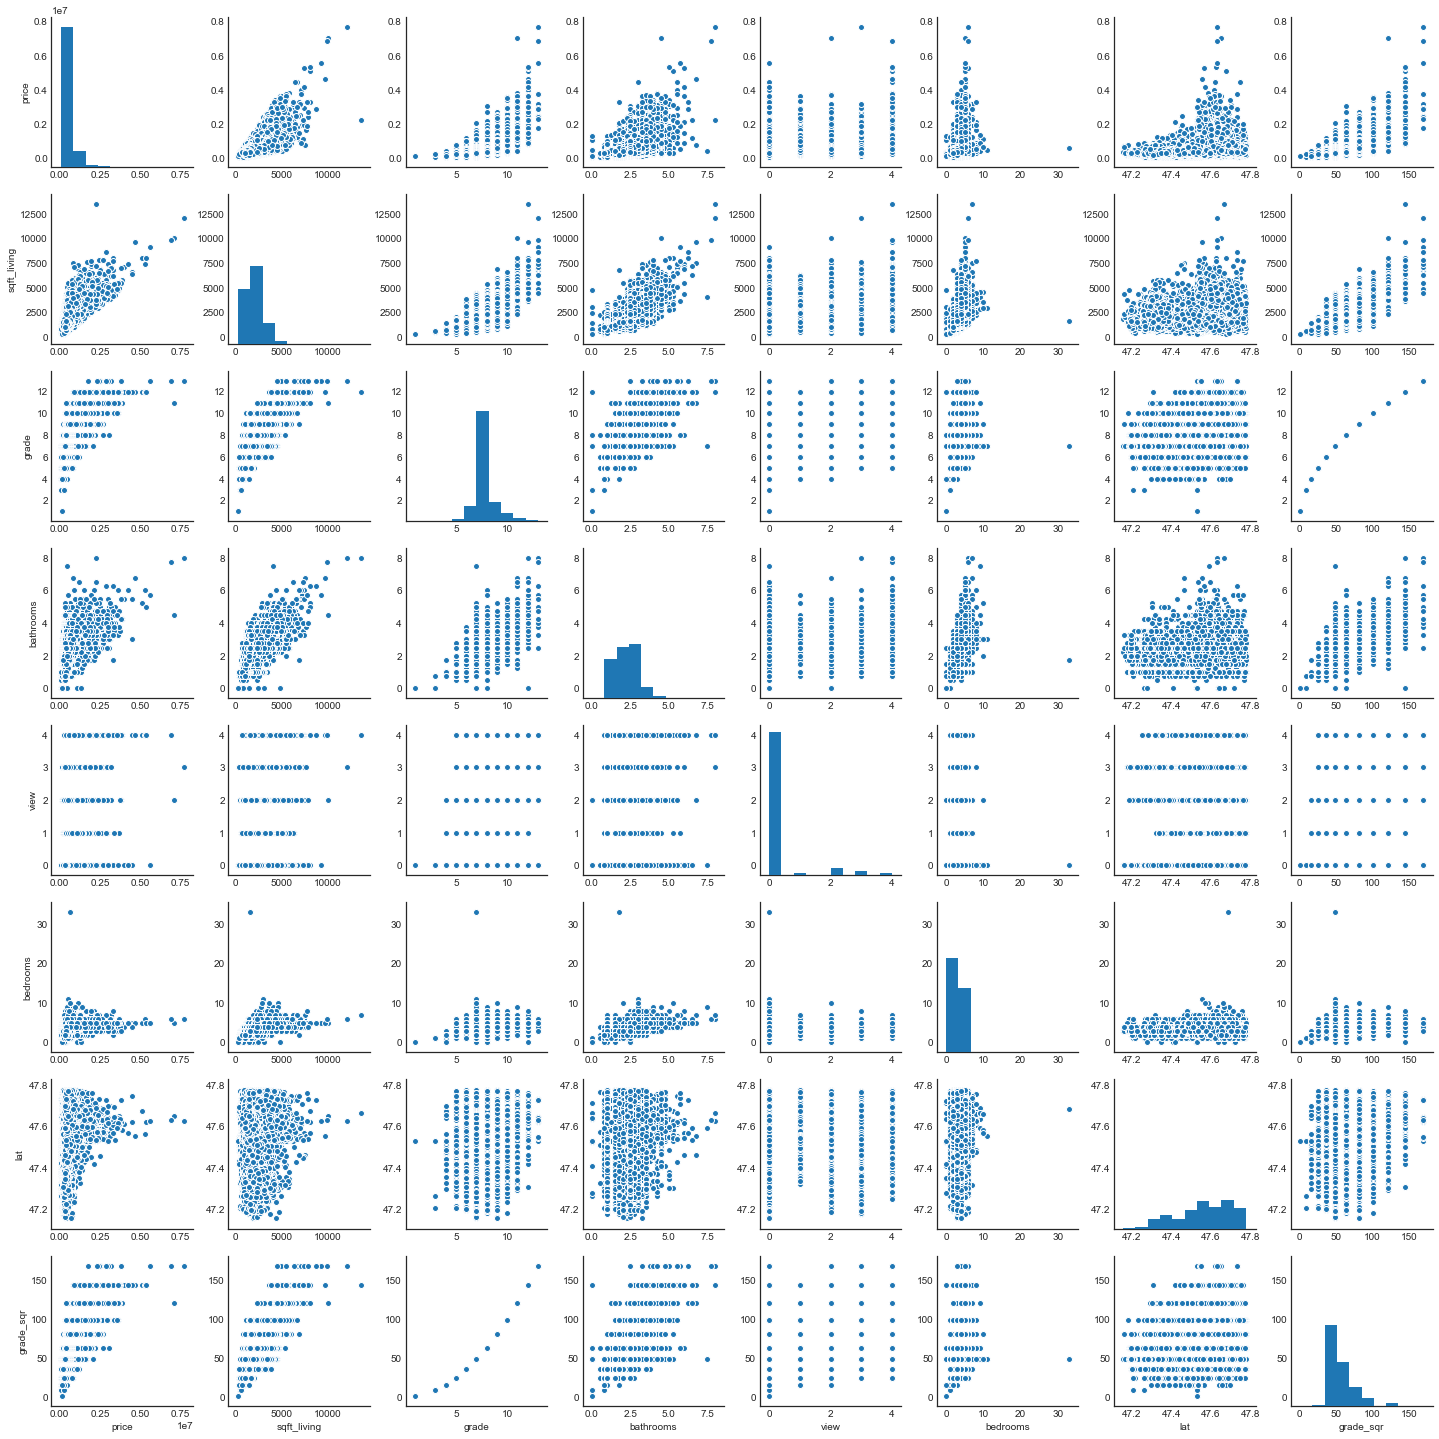

In [4]:
# Narrow down variables to those with the highest correlations overall, and of similar types
correlations = housing.corr().loc[:,'price'].abs().sort_values(ascending=False).index.values
correlations = pd.DataFrame(correlations)
top_vars = list(correlations.iloc[:10,0])
delete = ['sqft_above','sqft_living15','sqft_basement']
top_vars = [x for x in top_vars if x not in delete]

# Create variable subset
subset = housing[top_vars].copy()
subset['grade_sqr'] = subset['grade']**2

sns.pairplot(subset)
plt.show()

In [5]:
# Getting rid of old grade in favor of grade^2, which has more linear relationship with price
# Dropping view, which does not have a linear relationship with the outcome despite its high correlation
subset = subset.drop(['grade','view'],axis=1)
subset.head()

,price,sqft_living,bathrooms,bedrooms,lat,grade_sqr
0,221900.0,1180,1.00,3,47.5112,49
1,538000.0,2570,2.25,3,47.7210,49
2,180000.0,770,1.00,2,47.7379,36
3,604000.0,1960,3.00,4,47.5208,49
4,510000.0,1680,2.00,3,47.6168,64


In [6]:
subset.corr()

,price,sqft_living,bathrooms,bedrooms,lat,grade_sqr
price,1.000000,0.702035,0.525138,0.308350,0.307003,0.692402
sqft_living,0.702035,1.000000,0.754665,0.576671,0.052529,0.772359
bathrooms,0.525138,0.754665,1.000000,0.515884,0.024573,0.656125
bedrooms,0.308350,0.576671,0.515884,1.000000,-0.008931,0.344695
lat,0.307003,0.052529,0.024573,-0.008931,1.000000,0.110764
grade_sqr,0.692402,0.772359,0.656125,0.344695,0.110764,1.000000


Grade_sqr, sqft_living, bathrooms, and bedrooms all have pretty high correlations, so let's keep that in mind when making the model, since they could be a good use case for dimensionality reduction.

__First, regular linear regression with all of these features__

In [7]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
features = ['sqft_living','bathrooms','bedrooms','lat','grade_sqr']

Y = subset['price']
X = subset[features]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X)
actual = Y

# Calculate residuals
residual = actual - predicted
residual = pd.to_numeric(residual)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual,predicted)
rmse = np.sqrt(mse)
print('\n RMSE: {}'.format(rmse))


Coefficients: 
 [  2.07734569e+02  -1.99806547e+04  -3.04493930e+04   6.48665510e+05
   6.08175263e+03]

Intercept: 
 -30962612.3282

R-squared:
0.614380636218

 RMSE: 227974.31920734546


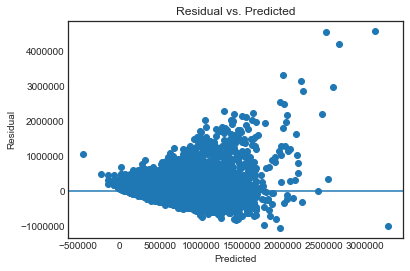

In [8]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Not so great. Let's do the same with a partial least squared model to see if that does any better.

In [9]:
# Cross validation
from sklearn.model_selection import cross_val_score
score = cross_val_score(regr, X, Y, cv=5, scoring='r2')
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = cross_val_score(regr, X, Y, cv=5, scoring='neg_mean_squared_error')
print("RMSE: %0.2f (+/- %0.2f)" % (np.sqrt(np.abs(score.mean())), score.std() * 2))

Unweighted Accuracy: 0.61 (+/- 0.03)
RMSE: 228283.89 (+/- 11225908130.60)


In [10]:
# Partial least squares regression, 3 components (I messed with this for the highest r^2 possible)
pls1 = PLSRegression(n_components=3)

# Reduce X to R(X) and regress on y.
pls1.fit(X, Y)

# Save predicted values.
Y_PLS_pred = pls1.predict(X)
print('R-squared PLSR:', pls1.score(X, Y))

R-squared PLSR: 0.610421869745


In [11]:
# Cross validation
from sklearn.model_selection import cross_val_score
score = cross_val_score(pls1, X, Y, cv=5, scoring='r2')
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = cross_val_score(pls1, X, Y, cv=5, scoring='neg_mean_squared_error')
print("RMSE: %0.2f (+/- %0.2f)" % (np.sqrt(np.abs(score.mean())), score.std() * 2))

Unweighted Accuracy: 0.61 (+/- 0.03)
RMSE: 229479.14 (+/- 11589822973.27)


Doesn't make much of a difference. Let's try a KNN model:

# KNN Model
Let's first try it with the same features as the regression model, without any weighting. We'll need to normalize the variables first.

In [12]:
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler

# Build our model.
features.append('zipcode')
subset['zipcode'] = housing['zipcode']

# Normalize the variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feat_scaled = scaler.fit_transform(subset[features])

knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(feat_scaled)
Y = subset['price']
knn.fit(X, Y)

# Extract predicted values.
predicted = knn.predict(X)
actual = Y

# Calculate residuals
residual = actual - predicted
residual = pd.to_numeric(residual)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual,predicted)
rmse = np.sqrt(mse)
print('\n RMSE: {}'.format(rmse))
print('\n R^2: {}'.format(knn.score(X,Y)))


 RMSE: 153117.1322437124

 R^2: 0.8260459470096773


And some cross validation.

In [13]:
score = cross_val_score(knn, X, Y, cv=5, scoring='r2')
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = cross_val_score(knn, X, Y, cv=5, scoring='neg_mean_squared_error')
print("RMSE: %0.2f (+/- %0.2f)" % (np.sqrt(np.abs(score.mean())), score.std() * 2))

Unweighted Accuracy: 0.77 (+/- 0.02)
RMSE: 175481.23 (+/- 8281426273.63)


Though $r^2$ is slightly less consistent, we're seeing a big performance upgrade vs the linear model. Let's try with some weighting.

In [14]:
# Build our model.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10,weights='distance')
X = pd.DataFrame(feat_scaled)
Y = subset['price']
knn_w.fit(X, Y)

# Extract predicted values.
predicted = knn_w.predict(X)
actual = Y

# Calculate residuals
residual = actual - predicted
residual = pd.to_numeric(residual)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual,predicted)
rmse = np.sqrt(mse)
print('\n RMSE: {}'.format(rmse))
print('\n R^2: {}'.format(knn_w.score(X,Y)))


 RMSE: 10943.638614278163

 R^2: 0.9991113914959856


Woah, much more accurate! May be overfitting, though...

In [15]:
score = cross_val_score(knn_w, X, Y, cv=5, scoring='r2')
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = cross_val_score(knn_w, X, Y, cv=5, scoring='neg_mean_squared_error')
print("RMSE: %0.2f (+/- %0.2f)" % (np.sqrt(np.abs(score.mean())), score.std() * 2))

Unweighted Accuracy: 0.77 (+/- 0.02)
RMSE: 174413.71 (+/- 7952550979.14)


So it looks like we may be overfitting, so I'll keep weighting out of the mix. Let's go back to the unweighted model, but this time take advantage of how KNN can involve more variables that may not have a linear relationship with the outcome variable, like zip code. We know that real estate pricing is a complex mix of different components, a very important one of which is location. Let's see if KNN can incorporate this even more than just including latitude.

In [16]:
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler

# Build our model.
features.append('zipcode')
subset['zipcode'] = housing['zipcode']

# Normalize the variables again
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feat_scaled = scaler.fit_transform(subset[features])

knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(subset[features])
Y = subset['price']
knn.fit(X, Y)

# Extract predicted values.
predicted = knn.predict(X)
actual = Y

# Calculate residuals
residual = actual - predicted
residual = pd.to_numeric(residual)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual,predicted)
rmse = np.sqrt(mse)
print('\n RMSE: {}'.format(rmse))
print('\n R^2: {}'.format(knn.score(X,Y)))


 RMSE: 202654.48705465766

 R^2: 0.6952810753801649


In [17]:
score = cross_val_score(knn, X, Y, cv=5, scoring='r2')
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = cross_val_score(knn, X, Y, cv=5, scoring='neg_mean_squared_error')
print("RMSE: %0.2f (+/- %0.2f)" % (np.sqrt(np.abs(score.mean())), score.std() * 2))

Unweighted Accuracy: 0.60 (+/- 0.02)
RMSE: 230346.18 (+/- 7716632182.06)


This actually decreases our accuracy, so I guess zip is just not the beast measure to use. Let's instead see what happens when we include all compatible features, minus zip, id, and date which don't really make sense as KNN variables.

I'm also going to then mess with the number of neighbors included, to see if we can improve on the original five feature model.

In [18]:
full_feat = [x for x in housing.columns if x not in ['id','price','date','zipcode']]
print(full_feat)

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [19]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feat_scaled = scaler.fit_transform(housing[full_feat])

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=3)
X = pd.DataFrame(feat_scaled)
Y = housing['price']
knn.fit(X, Y)

# Extract predicted values.
predicted = knn.predict(X)
actual = Y

# Calculate residuals
residual = actual - predicted
residual = pd.to_numeric(residual)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual,predicted)
rmse = np.sqrt(mse)
print('\n RMSE: {}'.format(rmse))
print('\n R^2: {}'.format(knn.score(X,Y)))


 RMSE: 117098.69940542629

 R^2: 0.8982601432567147


In [20]:
score = cross_val_score(knn, X, Y, cv=5, scoring='r2')
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = cross_val_score(knn, X, Y, cv=5, scoring='neg_mean_squared_error')
print("RMSE: %0.2f (+/- %0.2f)" % (np.sqrt(np.abs(score.mean())), score.std() * 2))

Unweighted Accuracy: 0.79 (+/- 0.04)
RMSE: 169619.83 (+/- 8764242583.16)


This one actually performs slightly better than the original model. Interestingly it performs better with a few neighbors, as opposed to only 1 or many.

Just validating how cross_val_score is working...

In [21]:
predicted.shape

(21613,)

In [22]:
actual.shape

(21613,)

In [23]:
residual.shape

(21613,)

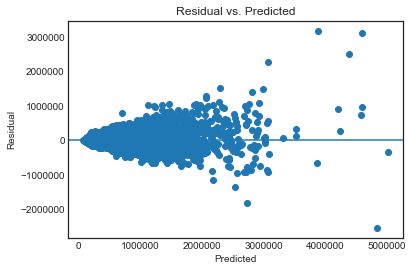

In [24]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [25]:
# Using sklearn to create different folds, just as confirmation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=3)

from sklearn.metrics import r2_score

for train, test in kf.split(housing):
    
    knn = neighbors.KNeighborsRegressor(n_neighbors=3)
    
    Xtrain = X.iloc[train,:].loc[:,:]
    Ytrain = housing.iloc[train,:].loc[:,['price']]
    
    knn.fit(Xtrain, Ytrain)
    
    Xtest = X.iloc[test,:].loc[:,:]
    Ytest = housing.iloc[test,:].loc[:,['price']]
    
    predicted = knn.predict(Xtest).flatten()
    actual = np.array(Ytest)
    
    print('\nR-squared:')
    print(r2_score(actual, predicted))
    mse = mean_squared_error(actual,predicted)
    rmse = np.sqrt(mse)
    print('\n RMSE: {}'.format(rmse))


R-squared:
0.795459770964

 RMSE: 162033.60025818317

R-squared:
0.760348526027

 RMSE: 186411.17483562068

R-squared:
0.802989030709

 RMSE: 161217.83278318224

R-squared:
0.783040508188

 RMSE: 167067.90461304458

R-squared:
0.764838501729

 RMSE: 181408.34091520324


# Conclusion
Our KNN model substantially outperforms the linear regression model we created. As we know, real estate prices are a complex coalescence of many different attributes. While linear regression has the advantage of being highly generalizable when done right, it misses many of the nuances that dictate specific housing prices as a result of boiling the model down to valid features. KNN doesn't suffer from this, and is able to incorporate many different variables, including those that don't have a linear relationship with the outcome variable. This complexity is why I think it performs better than the linear model.

A couple other interesting points:
- The KNN model also seems to miss in a different way than the linear regression. It demonstrates much less heteroscedasticity and seems to give better predictions for low price predictions given the complexity that the model captures (unlike the linear regression). Similarly, it seems to do less underpredicting on the high end of predicted prices, probably also due to the complexity of the model, which is able to more accurately predict outlying values.
- The KNN model also does better with a few neighbors, as opposed to one or many. I suspect that this is because too few will lead to overfitting, and too many causes the model to lose the complexity that is driving its superior performance.